# Programming session of Char RNN 

Please note that, this programming session is not made with the intention of building the best model for char RNN. Rather, the idea is to build a rudimentray setup to explain the theory we discussed in the tutorial and train RNNs using PyTorch. Thus I don't use  batch training, dropouts, complex models like LSTMs, truncated backpropagation, validation and testing sets, learning rate decay and other optimizations. 

In the next part of this tutorial series, which is the real project I'm interested in, THERE WILL BE A KICKASS MODEL !

### Install PyTorch 0.4 with CUDA support

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [8]:
import torch
print("PyTorch Version: ",torch.__version__)
print("Cuda availability: ", torch.cuda.is_available())

PyTorch Version:  0.4.0
Cuda availability:  True


### Import PyTorch and other required libraries

In [0]:
import torch.nn as nn
import numpy as np
import random
from random import randint
from torch.nn.utils import clip_grad_norm_

Device information will display the computation device, CPU or GPU. RNNs are infamous for their hunger for data and computation, GPUs are preferred for training RNNs.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Get data

Once run, this will allow you to manually select the path on local drive for file you wish to upload. Here we are using tiny shakespheare dataset which can be downloaded from [here](https://github.com/karpathy/char-rnn/raw/master/data/tinyshakespeare/input.txt).


In [11]:
from google.colab import files
uploaded = files.upload()
for train in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=train, length=len(uploaded[train])))

Saving tiny_shakespheare.txt to tiny_shakespheare (1).txt
User uploaded file "tiny_shakespheare.txt" with length 1115394 bytes


### Process data

Here we are processing the data read from our input text file. 

1. First we get the number of characters present in the entire dataset.  This set has english alphabets, special characters, space and next line .  Can you spot the next line (`\n`) on print? ;)

2. Count of this entire set is called the `vocab_size`.  This parameter has significance as we move along. 

3. Second, we generated two dictionaries. One for mapping characters to IDs and the other of mapping vice-versa. Why they are required? Let's see later. 


In [12]:
# data I/O
data = open('tiny_shakespheare.txt', 'r').read() # should be simple plain text file

chars = list(set(data))
print("All available characters: ", "".join(chars))

data_size, vocab_size = len(data), len(chars)

print('\nData has {} characters, in which {} unique.'.format(data_size, vocab_size))

print("Vocabulary size is ", vocab_size)

letterToIndex = { ch:i for i,ch in enumerate(chars)}
print("Index of A is ", letterToIndex['A'])

indexToChar = { i:ch for i,ch in enumerate(chars)}
print("Character with 10 as index is ", indexToChar[10])


All available characters:  Ef3iC
.roL;Islpcnb: YFRAuQk'$vUdyKWPBDGX-TON!jgMVHJeahzm&wZ?Sx,qt

Data has 1115394 characters, in which 65 unique.
Vocabulary size is  65
Index of A is  23
Character with 10 as index is  ;


### Functions required

Here we define all the required functions in favor of training and testing our language model. 

* `lineToInputTensor` 

This function help us to convert a line of text to the mathematical representation of a tensor. The tensor dimensions are `[number of RNN cells x size of the batch x number of letters]`. This is a convention for convenience while standard RNN cell of PyTorch. Though, here we are using our own custom model for RNN to explain the equations, we follow this convention. 

Since we don't use batch training here, the dimensions change to `[number of RNN cells x 1 x number of letters]`. 


* `lineToTargetTensor` 

This function helps to convert the target sentence to a tensor with it's IDs. Why not one-hot vectors? We use `CrossEntropyLoss` as loss function for our model. PyTorch expect target of it to be a `LongTensor` or a tensor with integer values.

* `learning_rate_decay`

This function help us to reduce the learning rate monotonously as the iteration progress. This will help to stabilize the loss reduction rather than erractic ups and downs


In [0]:
def lineToInputTensor(line, vocab_size):
    """
    Turn a input line of string into a <seq_length x 1  x number of letters> tensor of one-hot letter vectors
    """
    tensor = torch.zeros(len(line), 1, vocab_size)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex[letter]] = 1
    return tensor


def lineToTargetTensor(line):
    """
    Turn a output line of string into a <lenght of the line x 1 > tensor with it's respective id numbers
    """
    tensor = torch.LongTensor(len(line))
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex[letter]
    return tensor.unsqueeze(-1)

def sample(model, input_hidden_state, starting_letter, num_samples):
    
    # Sample to understand the improvement
    output_string = ""
    input_vector = lineToInputTensor(starting_letter, vocab_size).to(device)
    
    for i in range(num_samples):
        # Forward propagate RNN 
        output, input_hidden_state = model(input_vector[0], input_hidden_state)

        # Sample a word id
        prob = output.exp()
        char_id = torch.multinomial(prob, num_samples=1).item()

        # Fill input with sampled word id for the next time step
        input_vector = lineToInputTensor(indexToChar[char_id], vocab_size).to(device)

        # File write
        char = indexToChar[char_id]
        char = '\n' if char == '.' else char + ''
        output_string += char
    return output_string

In [14]:
# Converting a line of text to a tensor

print(lineToInputTensor("Sleeba", vocab_size))

print("\nTensor shape: ",lineToInputTensor("Sleeba", vocab_size).shape)

tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,

In [15]:
# Convert the target to a tensor

print(lineToTargetTensor("Sleeba"))
print("\nTensor shape: ",lineToTargetTensor("Sleeba").shape)

tensor([[ 60],
        [ 13],
        [ 51],
        [ 51],
        [ 17],
        [ 52]])

Tensor shape:  torch.Size([6, 1])


In [0]:
# Store all the lines to a string so that we can seek through this string while training 

lines = ""
with open('tiny_shakespheare.txt', 'r') as f:
    for line in f:
        lines += line

In [0]:
class DetailedRNN(nn.Module):
    """
    PyTorch give us the freedom of creating the custom models we need to define by inheriting nn.Module.
    We are going to create our RNN cell rather than using inbuilt RNN cell of PyTorch. 
    """
    def __init__(self, input_size, hidden_size, output_size):
        
        super(DetailedRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.tanh = nn.Tanh()
     
        self.i2h = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        self.i2o = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        # Forward pass of our RNN cell
        combined = torch.cat((input, hidden), 1)
        hidden_layer = self.i2h(combined)
        hidden_layer = self.tanh(hidden_layer)
        output = self.i2o(hidden_layer)
        output = self.softmax(output)
        return output, hidden_layer
    
    def init_hidden(self):
        """
        Initialize hidden states and cell states to zeros
        """
        return torch.zeros(1, hidden_size)

In [0]:
# Hyper-parameters

hidden_size = 512 # No of hidden nuerons in a cell 
seq_length = 25   # No of time steps we're unfolding the RNN to. 
learning_rate = 0.001 # Fixed learning rate. You may try a decaying one. 
num_samples = 200  # No of characters we sample every now and then, to understand the changes. 

In [0]:
# Initialize the model 

model = DetailedRNN(vocab_size, hidden_size, vocab_size).to(device)
hidden_state = model.init_hidden().to(device)

In [0]:
# Loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
# Train the model
# Set initial hidden and cell states

loss_list = [] # A list to monitor loss at every 100th iterations and plot the same later 
num_steps = len(lines) // seq_length  # How many total time steps? If you've got the concept, then the equation is understood. 
lines = lines[:num_steps * seq_length+1] # We slice out that incomplete tail of lines which has a length less than seq_length


for i in range(0, num_steps * seq_length, seq_length):

    # Get sequence length inputs and targets
    # Eg. 
    
    # input = Sleeba Paul is a good boy
    # Target = leeba Paul is a good boy. 
    # We map S to l, l to e and so on
    # Length of this sequence is seq_length
    # This is how we seek through the entire text corpus
    
    input_line = lines[i:i+seq_length]
    inputs = lineToInputTensor(input_line, vocab_size).to(device)

    targets_line = lines[(i+1):(i+1)+seq_length]
    targets = lineToTargetTensor(targets_line).to(device)
    
    loss = 0
    optimizer.zero_grad() # This is important since we want to reset the gradients at beginning of each sequence

    for idx in range(len(input_line)):
        # Forward pass
        outputs, hidden_state = model(inputs[idx], hidden_state)
        loss += criterion(outputs, targets[idx])  # Note that we are updating weights at the end of a complete sequence, not at every character step
    
    loss.backward()  # Backpropagation through time is just a line of code in PyTorch ;)
    optimizer.step() # Update weights
    
    # The following step is really really important ! We are considering a sequence at once and optimize the loss from it
    # For each sequence, there will be a hidden_state passed initially. At the very beginning it is a zero tensor. 
    # As we progress, this tensor get changed and it is a variable. If we don't detach hidden_state from our computation graph after each sequence, 
    # optimizer will go all the way to the beginning to get this vector. 
    # In first iteration this is fine, but as iterations goes up, this small mistake from our side will cost us hours in training
    # Eg. At iteration 10000, the optimizer has to go back 10000 steps back to get the hidden state value !!!!
    # This can lead to vanishing gradients. So by detaching hidden_state from main computation graph, we treat it as a constant input when starting a sequence
    
    hidden_state = hidden_state.detach() 

    # Sample at every step of 100 iterations
    step = (i+1) // seq_length
    if step % 1000 == 0:
        print('The learning rate was set to {}'.format(learning_rate))
        print ('Iterations [{}/{}], Loss: {:.4f}'.format(step, num_steps, loss.item()))
        starting_letter = random.choice(list(indexToChar.values()))
        print("Randomly selected starting letter for sampling: {}".format(starting_letter))
        
        print("_________________________________________________\n")
        
        output_string = sample(model, hidden_state, starting_letter, num_samples)
        print(starting_letter + output_string)
        print("===============================================================\n")
        
    if step % 100 == 0:
        loss_list.append(float(loss))

The learning rate was set to 0.001
Iterations [0/44615], Loss: 104.0213
Randomly selected starting letter for sampling: I
_________________________________________________

Ietun
Qw,jPYMcube!WuT Ghj!UA jlOwY?mAUx
 ?yYrHd-ElZi-GDY&e3xo3kxNJyyr!J Nw:&K
lkL
F?kKg uhY?pLkho
RauCybvFQGUG-kCUgI?PjkrkE$ JAL3aYmdSJJTDKtHKQsKmvopuKnIQ'-khgFJUm Cmm$HkQ
XlCJDGqbSt;GiKbC-UciP,u&
k!Jr

The learning rate was set to 0.001
Iterations [1000/44615], Loss: 57.3767
Randomly selected starting letter for sampling: W
_________________________________________________

Woou;
Her Mora'ss
Mes, Sy ar tus ainicn sser, therenss year fvey toven thavt fsass bs
 Lpbs ThprisNkeniwsy gy andtkendn,
Powirca;h tace, tiga thours the, ilunl,
cous ousdithangus an, psinjcathaeveew os

The learning rate was set to 0.001
Iterations [2000/44615], Loss: 59.9158
Randomly selected starting letter for sampling: 

_________________________________________________


Furss Yo han co is met
USes sire Lakt y and an
dhach of tr phosind Mar

The learning rate was set to 0.001
Iterations [20000/44615], Loss: 57.0486
Randomly selected starting letter for sampling: O
_________________________________________________

O heer in sus my my eathith hime'amy ay toye wire oume,
Oige!e on amees, the thay shy dathe thes a ware
Thaue the vase mbytull thou weall waet ay uowait no farelisbagutmerh beitg with in may, meark ay 

The learning rate was set to 0.001
Iterations [21000/44615], Loss: 46.1893
Randomly selected starting letter for sampling: q
_________________________________________________

q hithdd bene Thount

And thy obt on be hios cires,
Fhath thy foree
-
BRofe the lanteath;
Ther yaiteot mhese fald bate or ow a, pelmenf he, if od antihid this Inee shy eallen helps thy thit hot:
Wall I

The learning rate was set to 0.001
Iterations [22000/44615], Loss: 45.3125
Randomly selected starting letter for sampling: e
_________________________________________________

e earnis,
No, I tie ? Ircks spiin, brcath;
Rocost this nine wonco,

The learning rate was set to 0.001
Iterations [40000/44615], Loss: 57.5407
Randomly selected starting letter for sampling: v
_________________________________________________

ve my o ksern?

SREMIONo:
Ber fond at ye me spesees, siratio?

TRANIO:
Bartsess


SRENIO:
Nin ir, move wer?

HRARIO:
Kit is


RoRTIOSIE:
I, cofe


ARUMIO:
A salu oigh
Ser cord ar; Ta surd?
To weing
By


The learning rate was set to 0.001
Iterations [41000/44615], Loss: 54.8764
Randomly selected starting letter for sampling: d
_________________________________________________

do pornow, mas if a fald you ban me t that be tore


WimTASTAO:
Tifel hemathans mured of is sof ud wee ssan friyne prat


HAsTASSANHAABA me bilss bavursterded, fald mid pullurdaie,
A masprss rabe, e me

The learning rate was set to 0.001
Iterations [42000/44615], Loss: 58.7594
Randomly selected starting letter for sampling: K
_________________________________________________

Kot marey,
Gefeanged Beperfeel, gevanher the were:
I with-ot toret

In [0]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

In [23]:
num_samples = 5000     # number of words to be sampled
sample_text_generated = ""

# Test the model 
# Generate a chunk of text and write it to sample.txt

with torch.no_grad():
    with open('sample.txt', 'w') as f:
        # Set intial hidden ane cell states
        hidden_state = model.init_hidden().to(device)
        # Select one word id randomly
        starting_letter = random.choice(list(indexToChar.values()))
        print("Randomly selected starting letter for sampling: {}".format(starting_letter))
        
        input = lineToInputTensor(starting_letter, vocab_size).to(device)
        prob = torch.ones(vocab_size)
        for i in range(num_samples):
            # Forward propagate RNN 
            output, hidden_state = model(input[0], hidden_state)

            # Sample a word id
            prob = output.exp()
            char_id = torch.multinomial(prob, num_samples=1).item()

            # File write
            char = indexToChar[char_id]
            char = '\n' if char == '.' else char + ''
            sample_text_generated += char
            f.write(char)
            if (i+1) % 1000 == 0:
                print('Sampled [{}/{}] words and save to {}'.format(i+1, num_samples, 'sample.txt'))
                
            # Fill input with sampled word id for the next time step
            input = lineToInputTensor(indexToChar[char_id], vocab_size).to(device)
print("\nGenerated text\n------------------------------------------------------")
print(sample_text_generated)


Randomly selected starting letter for sampling: t
Sampled [1000/5000] words and save to sample.txt
Sampled [2000/5000] words and save to sample.txt
Sampled [3000/5000] words and save to sample.txt
Sampled [4000/5000] words and save to sample.txt
Sampled [5000/5000] words and save to sample.txt

Generated text
------------------------------------------------------
he this fenfane your tenat iptise pome thay hot shient, ss it me foe thy keidoles ap theo


SONION Kpobetgowst yaikn soce sorangrishis fouire pyous scud spoll ald, my I thiss al gand mast thes
leiousing',
And and apoe stadin; by;
Why brot; dath


ANTONO:
Wnich re,
And susewirnots I qo oovat you lethor noug the heip aid houls my ave ofune pringatst spauy he pite?
Woupht, lelinint fyot chanck, the minony ove appamerts,
Wim ast and
I migh heach rogatt khat me and thouith If doarist


ASEBOBOO::
Os soll
Whey fertaly,
Somy this
yetles you
thee; sir so tard, to wyor cage

De on thy ercasls thy
 Sandue? Hy to peicht himsonou sure


M

# Inference 

As we see, RNNs learned the conversation structure, names of characters, capital letters for sentence starting, questions ending with question marks, salutations followed by comma and many other things. 

Yes, most of the dialogues are still gibberish. But this is the rudimentary implementation of RNNs. Also,  note that our data is too small (1MB is already considered very small) the RNN won't learn very effectively. Remember that it has to learn everything  from scratch. Conversely if our data is large (more than about 2MB), it will work significantly better. 

Considering all these points,  RNNs have done a pretty good job. Most importantly, we learned the concepts really well. There are so many optimization can be brought into this model and come up with exceptional models that are creative and maintain context really well. 

Below is the loss v/s iterations graph. 

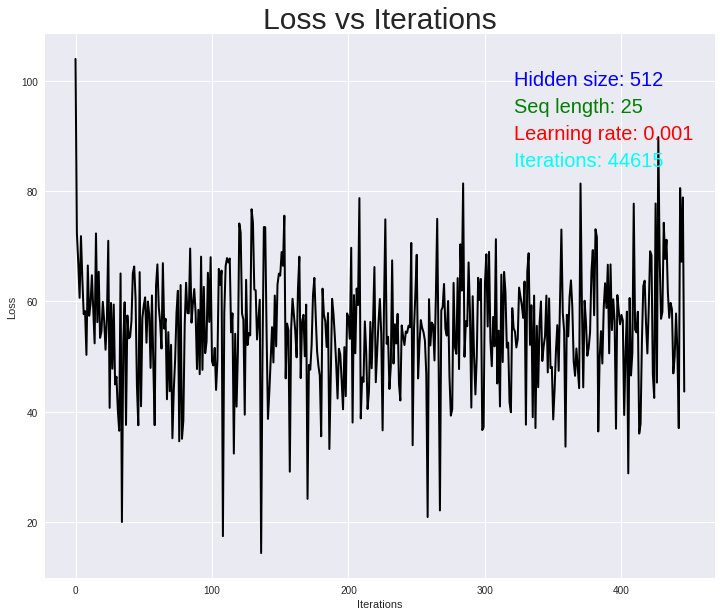

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

fig, ax = plt.subplots()
sns.set_style("ticks")
sns.set_context("poster")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations", fontsize=30)
# x = list(range(1, len(lines), seq_length))
y = loss_list
ax.text(0.7, 0.9, 'Hidden size: {}'.format(hidden_size),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Blue', fontsize=20)
ax.text(0.7, 0.85, 'Seq length: {}'.format(seq_length),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Green', fontsize=20)
ax.text(0.7, 0.80, 'Learning rate: {}'.format(learning_rate),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Red', fontsize=20)
ax.text(0.7, 0.75, 'Iterations: {}'.format(num_steps),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Cyan', fontsize=20)
plt.plot( y, color='black', linewidth = 2)
fig.set_size_inches(12, 10)
plt.savefig("loss_iter_graph.png", dpi=600)
plt.show()

In [0]:
files.download('sample.txt')

In [0]:
files.download("loss_iter_graph.png")

In [0]:
files.download('model.ckpt')